In [118]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import precision_score, recall_score, f1_score
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
#from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report, precision_recall_curve

In [119]:
df=pd.read_csv("../datasets/sensor.csv")
sensors_to_drop = ['Unnamed: 0', 'timestamp','sensor_15', 'sensor_50']
df = df.drop(columns=sensors_to_drop)

sensor_cols = df.columns[df.isnull().any()].tolist()
df[sensor_cols] = df[sensor_cols].interpolate(method='linear')
df[sensor_cols] = df[sensor_cols].fillna(method='ffill')
df[sensor_cols] = df[sensor_cols].fillna(method='bfill')
y=df["machine_status"]
X=df.drop(columns=['machine_status'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.93, shuffle=False)
scaler=MinMaxScaler()
scaler.fit(X_train)
X_train=scaler.transform(X_train)
X_test=scaler.transform(X_test)
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

/tmp/ipykernel_8234/2220040279.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[sensor_cols] = df[sensor_cols].fillna(method='ffill')
/tmp/ipykernel_8234/2220040279.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[sensor_cols] = df[sensor_cols].fillna(method='bfill')


In [120]:
def save_broken_samples(X, y, broken_file="broken_samples.csv", prebroken_file="prebroken_samples.csv", offset=100):
    X = np.array(X)
    y = np.array(y)

    broken_indices = np.where(y == "BROKEN")[0]

    broken_samples = []
    prebroken_samples = []

    for idx in broken_indices:
        broken_samples.append(X[idx])
        if idx >= offset:
            prebroken_samples.append(X[idx - offset])

    # Save broken samples
    pd.DataFrame(broken_samples).to_csv(broken_file, index=False)
    print(f"Saved {len(broken_samples)} broken samples to '{broken_file}'")

    # Save pre-broken samples
    pd.DataFrame(prebroken_samples).to_csv(prebroken_file, index=False)
    print(f"Saved {len(prebroken_samples)} pre-broken samples to '{prebroken_file}'")
save_broken_samples(X_test, y_test, "broken_samples.csv", "notbroken.csv")

Saved 7 broken samples to 'broken_samples.csv'
Saved 7 pre-broken samples to 'notbroken.csv'


In [ ]:
def inject_faults(x, y, fault_fraction=0.1, decrease_fraction=0.3, decrease_value=0.2):
    # Create copies to avoid modifying original data
    x_fault = x.copy()
    y_fault = y.copy()

    n_samples, n_features = x_fault.shape

    # Determine number of samples to mark as faulty
    n_faulty = int(n_samples * fault_fraction)
    
    # Randomly select indices for the samples that will become faulty
    faulty_indices = np.random.choice(n_samples, size=n_faulty, replace=False)

    for idx in faulty_indices:
        # Mark the sample as faulty in y
        y_fault[idx] = "BROKEN"
        
        # Determine the number of features to decrease; ensure at least one feature is selected
        n_decrease = max(1, int(np.ceil(n_features * decrease_fraction)))
        
        # Randomly select feature indices in this sample
        feature_indices = np.random.choice(n_features, size=n_decrease, replace=False)
        
        # Apply a 20% decrease on the selected features
        x_fault[idx, feature_indices] *= (1 - decrease_value)
    
    return x_fault, y_fault

X_train, y_train = inject_faults(X_train, y_train, fault_fraction=0.05, decrease_fraction=0.3)


In [122]:
def extend_fault_labels(y, n_before=20):
    y_extended = list(y)
    for i, label in enumerate(y):
        if label == 'BROKEN':
            start_idx = max(0, i - n_before)
            for j in range(start_idx, i):
                y_extended[j] = 'BROKEN'
    return np.array(y_extended)

y_train_extended = extend_fault_labels(y_train, n_before=0)
y_test_extended  = extend_fault_labels(y_test, n_before=0)

def binary_label(y):
    return np.array([1 if label == 'BROKEN' else 0 for label in y])
y_train_bin = binary_label(y_train_extended)
y_test_bin  = binary_label(y_test_extended)

In [123]:
model = Sequential([
    Dense(64, activation='relu', input_shape=(50,)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print(np.unique(y_train_bin))
history = model.fit(X_train, y_train_bin, epochs=20, batch_size=128, validation_data=(X_test, y_test_bin))

#loss, accuracy = model.evaluate(X_test, y_test_bin)
#print("Test Loss:", loss)
#print("Test Accuracy:", accuracy)

[0 1]
Epoch 1/20


/home/henrik/anaconda3/envs/py310/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.8503 - loss: 0.2824 - val_accuracy: 1.0000 - val_loss: 0.0581
Epoch 2/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9893 - loss: 0.0569 - val_accuracy: 1.0000 - val_loss: 0.0544
Epoch 3/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9904 - loss: 0.0520 - val_accuracy: 1.0000 - val_loss: 0.0576
Epoch 4/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9897 - loss: 0.0552 - val_accuracy: 1.0000 - val_loss: 0.0570
Epoch 5/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.9892 - loss: 0.0567 - val_accuracy: 1.0000 - val_loss: 0.0668
Epoch 6/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9893 - loss: 0.0564 - val_accuracy: 1.0000 - val_loss: 0.0620
Epoch 7/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9887 - loss: 0.0585 - val_accuracy: 1.0000 - val_loss: 0.0660
Epoch 8/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9900 - loss: 0.0532 - val_accuracy: 1.000

6404/6404 ━━━━━━━━━━━━━━━━━━━━ 5s 806us/step


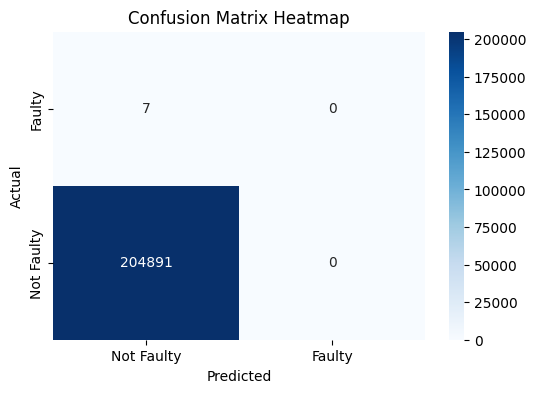

In [124]:
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob >= 0.5).astype(int)

cm = confusion_matrix(y_test_bin, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Faulty', 'Faulty'], yticklabels=['Not Faulty', 'Faulty'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.gca().invert_yaxis()
plt.show()

In [125]:
real_fault_indexes = np.where(y_test_bin == 1)[0]
predicted_fault_indexes = np.where(y_pred == 1)[0]
print("Indexes of real faults in the test set:")
print(real_fault_indexes)
print("\nIndexes of predicted faults:")
print(predicted_fault_indexes)

Indexes of real faults in the test set:
[  1733   9088  53896  62368 112618 125709 151018]

Indexes of predicted faults:
[]
